# Base Simulation Settings

In [144]:
from MieSppForce.simulation import SimulationConfig, SweepRunner,  DipoleCalculator, OpticalForceCalculator

import numpy as np
from pint import UnitRegistry
ureg = UnitRegistry()

base_config = SimulationConfig(
    wl = 900 * ureg.nanometer,
    R =  (295/2) * ureg.nanometer,
    dist = 2 * ureg.nanometer,
    angle = np.deg2rad(25),
    a_angle = np.pi/4,
    phase= np.pi/2
)

In [2]:
from MieSppForce.green_func_v2 import clear_cache

clear_cache()

In [145]:
from MieSppForce.simulation import CylindricalGrid, FieldsCalculator

grid = CylindricalGrid(
    r=np.linspace(0,3000, 100)*ureg.nm,
    phi=np.linspace(0, np.pi*2, 200)* ureg.radian,
    z=np.array([0.1]) * ureg.nm
)

gridFF = CylindricalGrid(
    r=20*base_config.wl,
    phi=np.linspace(0, np.pi*2, 200)* ureg.radian,
    z=np.array([0.0]) * ureg.nm
)

In [153]:
sweep_res, diagrams, _ = SweepRunner(base_config, 'wl', np.linspace(800, 1100, 100)*ureg.nanometer, True, True, True, False).run()

Sweeping 'wl':  87%|████████▋ | 87/100 [01:58<00:44,  3.39s/step]c:\Users\borod\Desktop\SPP_ANALYTICAL\SPP_ANALYTICAL\.venv\Lib\site-packages\scipy\integrate\_quadpack_py.py:444: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  im_retval = quad(imfunc, a, b, args, full_output, epsabs,
Sweeping 'wl':  93%|█████████▎| 93/100 [02:20<00:24,  3.53s/step]c:\Users\borod\Desktop\SPP_ANALYTICAL\SPP_ANALYTICAL\.venv\Lib\site-packages\scipy\integrate\_quadpack_py.py:444: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  im_retval = quad(imfunc, a, b, args, full_output, epsabs,
Sweeping 'wl': 100%|██████████| 100/100 [02:45<00:00,  1.66s/step]


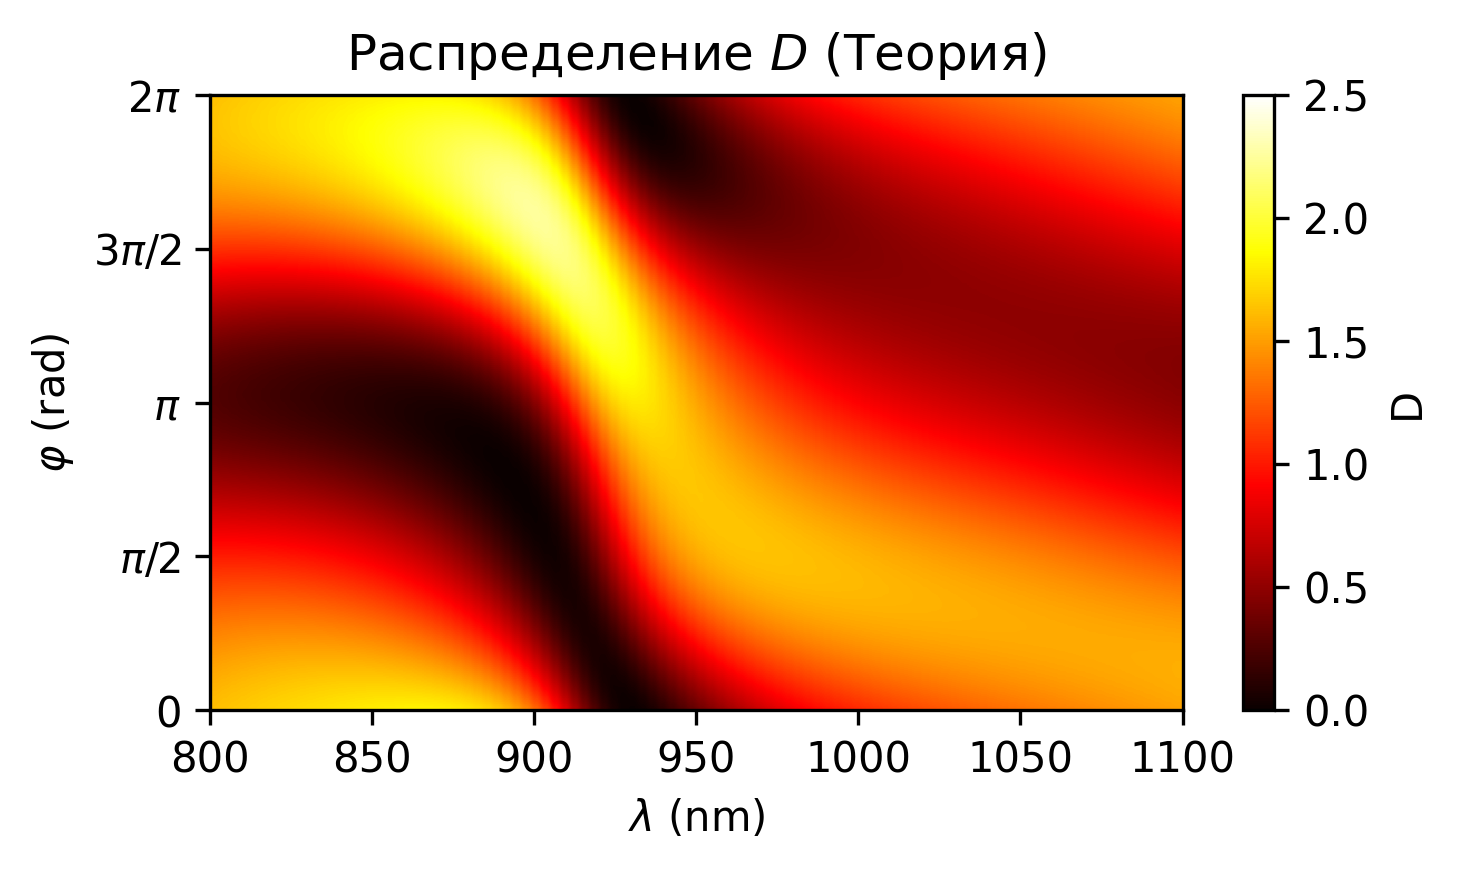

In [158]:
import numpy as np
import matplotlib.pyplot as plt

diagrams["phi"] = diagrams["phi"].apply(lambda x: x.magnitude if hasattr(x, "magnitude") else x)
diagrams["wl"]  = diagrams["wl"].apply(lambda x: x.magnitude if hasattr(x, "magnitude") else x)

pivot = diagrams.pivot(index="phi", columns="wl", values="D")

plt.figure(figsize=(5, 3), dpi=300)

plt.imshow(
    pivot.values.astype(float),
    aspect="auto",
    origin="lower",
    extent=[
        float(pivot.columns.min()), float(pivot.columns.max()),
        float(pivot.index.min()),   float(pivot.index.max())
    ],
    cmap="hot",
    vmin=0, vmax=2.5
)

plt.colorbar(label="D")
plt.xlabel("$\\lambda$ (nm)")
plt.ylabel("$\\varphi$ (rad)")
plt.title("Распределение $D$ (Теория)")

# Установка делений по оси Y в радианах
yticks = [0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi]
yticklabels = ["$0$", "$\\pi/2$", "$\\pi$", "$3\\pi/2$", "$2\\pi$"]

plt.yticks(yticks, yticklabels)

plt.tight_layout()
plt.savefig('plots/D_map_more.png', dpi=300)
plt.show()

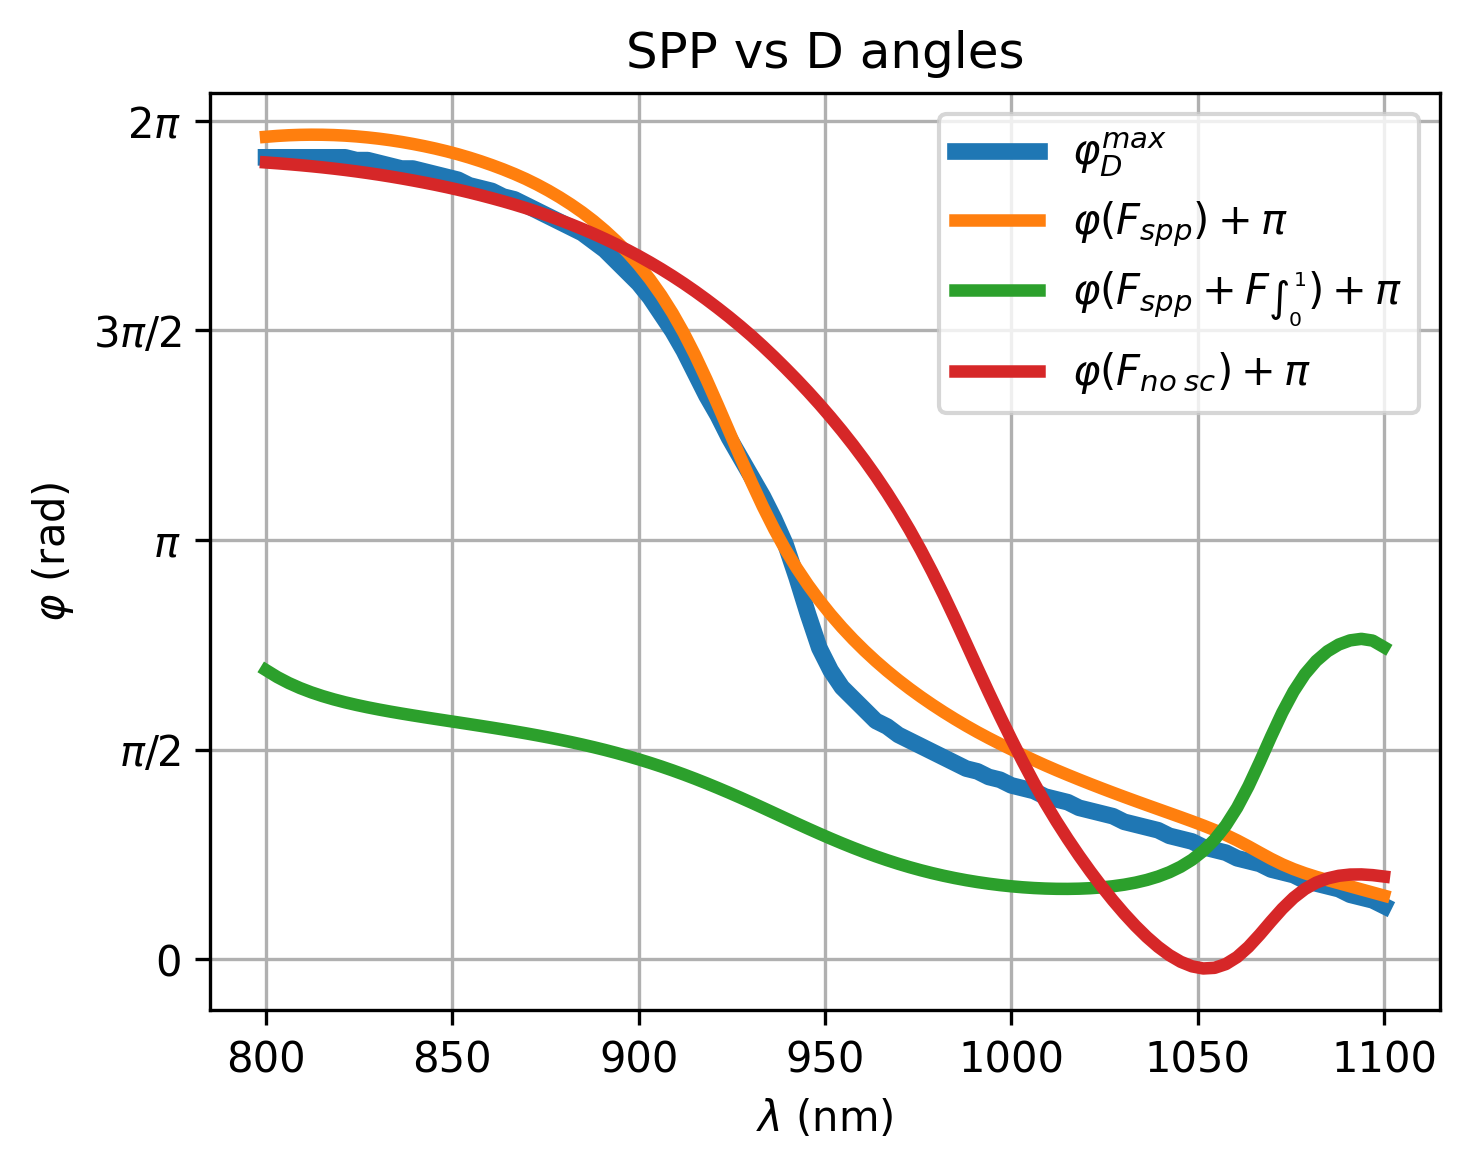

In [173]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# --- 1. phi_max из диаграмм ---
diagrams["phi"] = diagrams["phi"].apply(lambda x: x.magnitude if hasattr(x, "magnitude") else x)
diagrams["wl"]  = diagrams["wl"].apply(lambda x: x.magnitude if hasattr(x, "magnitude") else x)

phi_max = (
    diagrams.loc[diagrams.groupby("wl")["D"].idxmax()][["wl", "phi"]]
    .rename(columns={"phi": "phi_max"})
)

# --- 2. Угол силы ---
Fx = sweep_res["Fx"].apply(lambda x: x.to("N").magnitude).to_numpy()
Fy = sweep_res["Fy"].apply(lambda x: x.to("N").magnitude).to_numpy()
wl = sweep_res["wl"].apply(lambda x: x.magnitude if hasattr(x, "magnitude") else x).to_numpy()

Fxe0 = sweep_res["Fxe0"].apply(lambda x: x.to("N").magnitude).to_numpy()
Fxm0 = sweep_res["Fxm0"].apply(lambda x: x.to("N").magnitude).to_numpy()

Fxcross = sweep_res["Fxcross"].apply(lambda x: x.to("N").magnitude).to_numpy()
Fycross = sweep_res["Fycross"].apply(lambda x: x.to("N").magnitude).to_numpy()

Fx_nosc = Fx - Fxe0 - Fxm0

Fx_nosc_noncross = Fx_nosc - Fxcross
Fy_nosc_noncross = Fy - Fycross

Fxspp = sweep_res["Fxspp"].apply(lambda x: x.to("N").magnitude).to_numpy()
Fyspp = sweep_res["Fyspp"].apply(lambda x: x.to("N").magnitude).to_numpy()


theta_F = np.arctan2(Fy, Fx)

theta_F_nosc = np.arctan2(Fy, Fx_nosc)

theta_F_nosc_noncross = np.arctan2(Fy_nosc_noncross, Fx_nosc_noncross)

theta_F_spp = np.arctan2(Fyspp, Fxspp)


df_forces = pd.DataFrame({"wl": wl, "thetaFspp": theta_F_spp, "thetaFnosc_nocross": theta_F_nosc_noncross, "thetaFnosc": theta_F_nosc, "theta_F": theta_F })


df_plot = pd.merge(phi_max, df_forces, on="wl")


plt.figure(figsize=(5,4), dpi=300)

# plt.plot(df_plot["wl"], df_plot["phi_max"], label="$\\varphi_D^{max}$", lw=4)
# plt.plot(df_plot["wl"], df_plot["theta_F"], label="$\\varphi_F$", lw=4)

plt.plot(df_plot["wl"], df_plot["phi_max"], label="$\\varphi_D^{max}$", lw=4)
plt.plot(df_plot["wl"], df_plot["thetaFspp"]+np.pi, label="$\\varphi(F_{spp})+\\pi$",  lw=3)

plt.plot(df_plot["wl"], df_plot["thetaFnosc_nocross"]+np.pi, label="$\\varphi(F_{spp} + F_{\\int_0^1})+\\pi$",  lw=3)

plt.plot(df_plot["wl"], np.unwrap(df_plot["thetaFnosc"])+np.pi, label="$\\varphi(F_{no \\;sc})+\\pi$",  lw=3)

#plt.plot(df_plot["wl"], np.abs(df_plot["phi_max"]-df_plot["thetaFspp"]-np.pi), label="delta phi", marker="o")
yticks = [0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi]
yticklabels = ["$0$", "$\\pi/2$", "$\\pi$", "$3\\pi/2$", "$2\\pi$"]
plt.yticks(yticks, yticklabels)

plt.xlabel("$\\lambda$ (nm)")
plt.ylabel("$\\varphi$ (rad)")
plt.title("SPP vs D angles")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('plots/SPP_F_angles_more.png', dpi=300)
plt.show()

In [ ]:
sweep_res_air, diagrams_air, _ = SweepRunner(base_config, 'wl', np.linspace(800, 1100, 100)*ureg.nanometer, True, True, True, False, None, 'air').run()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

diagrams_air["phi"] = diagrams_air["phi"].apply(lambda x: x.magnitude if hasattr(x, "magnitude") else x)
diagrams_air["wl"]  = diagrams_air["wl"].apply(lambda x: x.magnitude if hasattr(x, "magnitude") else x)

pivot_air = diagrams_air.pivot(index="phi", columns="wl", values="D")

plt.figure(figsize=(5, 3), dpi=300)

plt.imshow(
    pivot_air.values.astype(float),
    aspect="auto",
    origin="lower",
    extent=[
        float(pivot_air.columns.min()), float(pivot_air.columns.max()),
        float(pivot_air.index.min()),   float(pivot_air.index.max())
    ],
    cmap="hot",
    vmin=0, vmax=2.5
)

plt.colorbar(label="D")
plt.xlabel("$\\lambda$ (nm)")
plt.ylabel("$\\varphi$ (rad)")
plt.title("Распределение $D_{air}$ (Theory)")

# Установка делений по оси Y в радианах
yticks = [0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi]
yticklabels = ["$0$", "$\\pi/2$", "$\\pi$", "$3\\pi/2$", "$2\\pi$"]

plt.yticks(yticks, yticklabels)

plt.tight_layout()
#plt.savefig('field/D_map_air.png', dpi=300)
plt.show()

In [174]:
#Free Space

base_config_free_space = SimulationConfig(
    wl = 900 * ureg.nanometer,
    R =  (295/2) * ureg.nanometer,
    dist = 2 * ureg.nanometer,
    angle = np.deg2rad(0),
    a_angle = 0,
    phase= 0,
    substrate='Air'
)

sweep_res_free_space, _, _ = SweepRunner(base_config_free_space, 'wl', np.linspace(800, 1100, 100)*ureg.nanometer, True, False, True, False).run()



Sweeping 'wl': 100%|██████████| 100/100 [00:03<00:00, 28.48step/s]


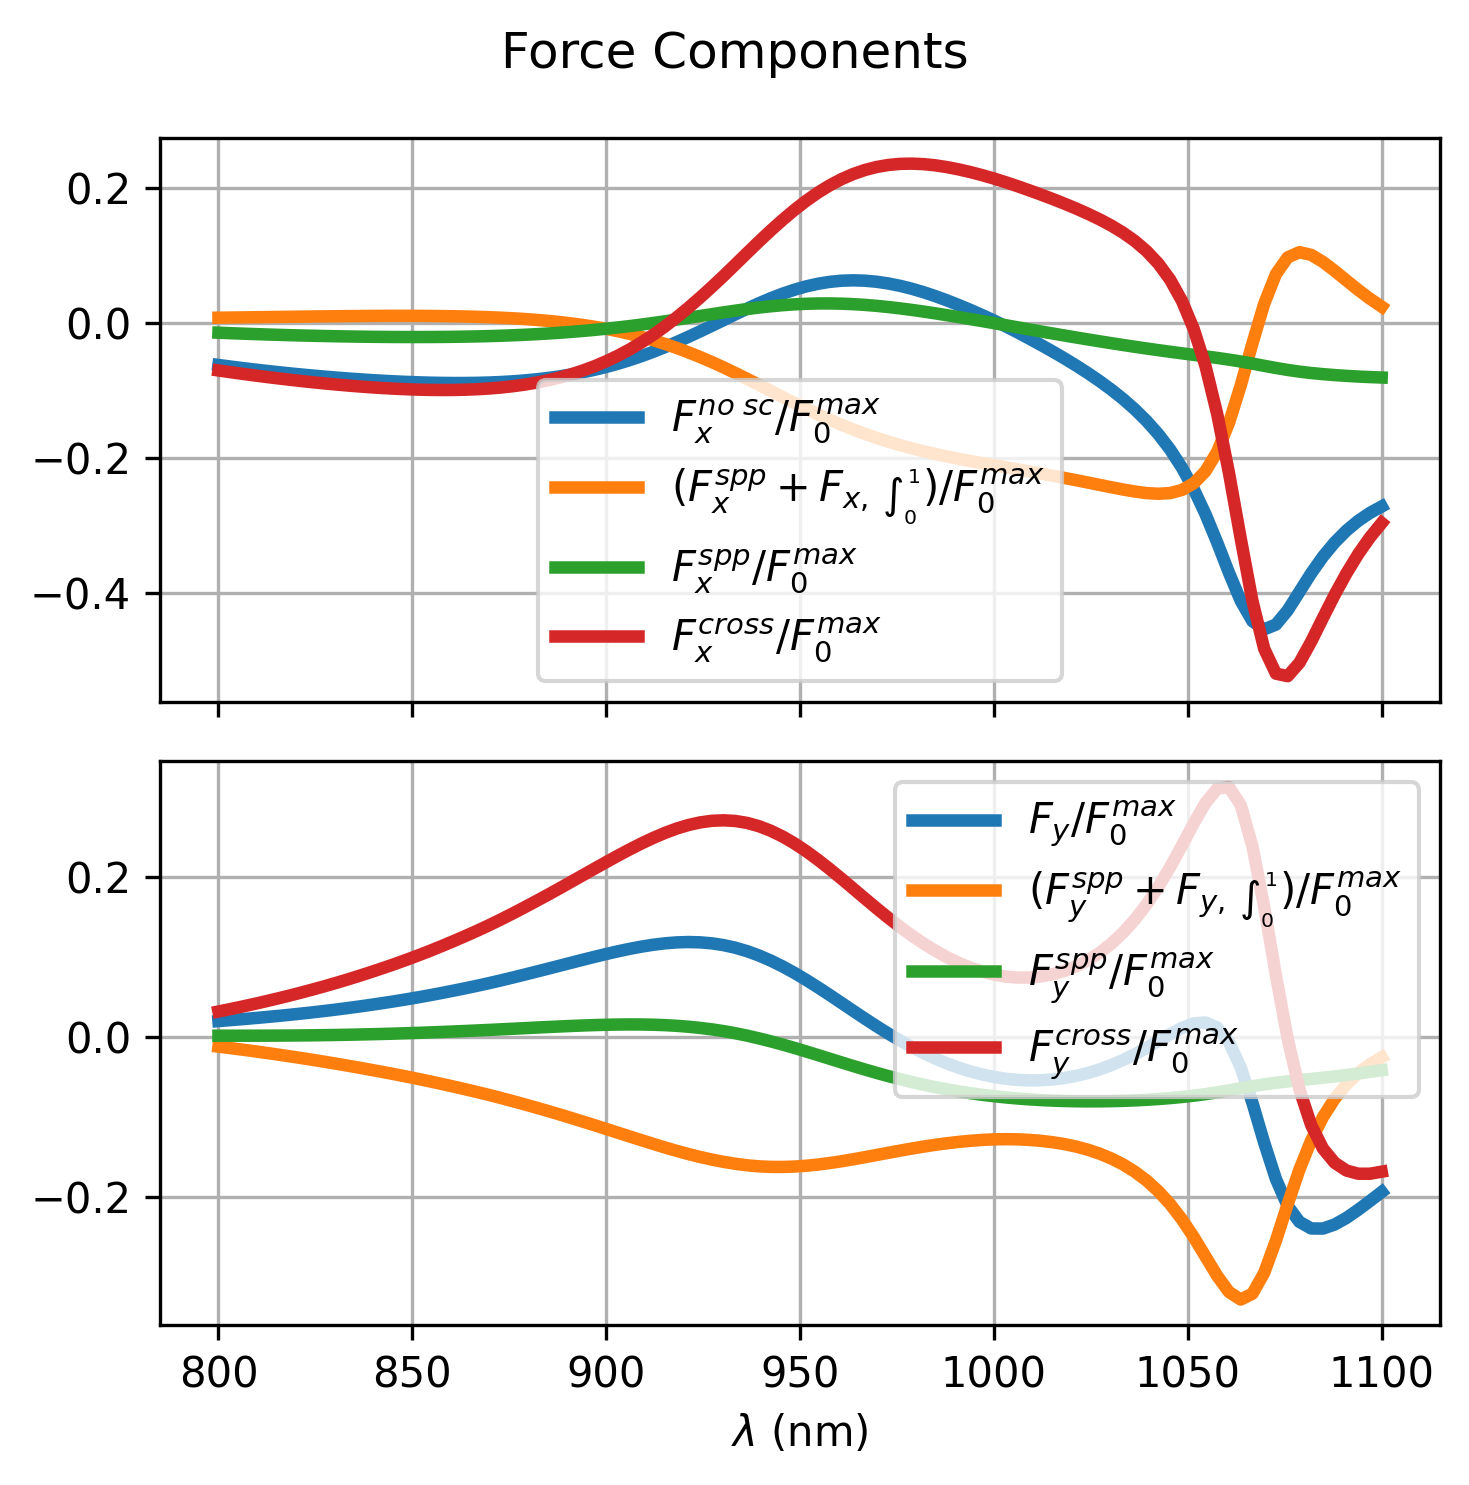

In [190]:
import numpy as np
import matplotlib.pyplot as plt

F0 = np.max(np.abs(sweep_res_free_space['Fz'].to_numpy()))

# --- 2. Угол силы ---
Fx = sweep_res["Fx"].to_numpy()
Fy = sweep_res["Fy"].to_numpy()
wl = sweep_res["wl"].apply(lambda x: x.magnitude if hasattr(x, "magnitude") else x).to_numpy()

Fxe0 = sweep_res["Fxe0"].to_numpy()
Fxm0 = sweep_res["Fxm0"].to_numpy()

Fxcross = sweep_res["Fxcross"].to_numpy()
Fycross = sweep_res["Fycross"].to_numpy()

Fx_nosc = Fx - Fxe0 - Fxm0

Fx_nosc_noncross = Fx_nosc - Fxcross
Fy_nosc_noncross = Fy - Fycross


Fxspp = sweep_res["Fxspp"].to_numpy()
Fyspp = sweep_res["Fyspp"].to_numpy()



Fx_norm      = np.array([f / F0 for f in Fx])
Fxnosc_norm  = np.array([f / F0 for f in Fx_nosc])
Fxnocross_norm = np.array([f / F0 for f in Fx_nosc_noncross])
Fxspp_norm   =  np.array([f / F0 for f in Fxspp])
Fxcross_norm   =  np.array([f / F0 for f in Fxcross])

Fy_norm      =  np.array([f / F0 for f in Fy])
Fynocross_norm =np.array([f / F0 for f in Fy_nosc_noncross])
Fyspp_norm   = np.array([f / F0 for f in Fyspp])
Fycross_norm   =  np.array([f / F0 for f in Fycross])

# --- графики ---
fig, axs = plt.subplots(2, 1, figsize=(5, 5),dpi=300, sharex=True)

#  X-компонента
# axs[0].plot(wl, Fx_norm, label="Fx / F0", marker="o")
axs[0].plot(wl, Fxnosc_norm, label="$F_x^{no\\;sc}/F_0^{max}$", lw=3)
axs[0].plot(wl, Fxnocross_norm, label="$(F_x^{spp}+F_{x,\\;\\int_0^1} )/ F_0^{max}$", lw=3)
axs[0].plot(wl, Fxspp_norm, label="$F_x^{spp} / F_0^{max}$", lw=3)
axs[0].plot(wl, Fxcross_norm, label="$F_x^{cross} / F_0^{max}$", lw=3)
# axs[0].set_ylabel("$F_x^{spp} / F_0^{max}$")
axs[0].legend()
axs[0].grid(True)

# Y-компонента
axs[1].plot(wl, Fy_norm, label="$F_y / F_0^{max}$", lw=3)
axs[1].plot(wl, Fynocross_norm, label="$(F_y^{spp}+F_{y,\\;\\int_0^1})/ F_0^{max}$", lw=3)
axs[1].plot(wl, Fyspp_norm, label="$F_y^{spp} / F_0^{max}$", lw=3)
axs[1].plot(wl, Fycross_norm, label="$F_y^{cross} / F_0^{max}$", lw=3)

# axs[1].set_ylabel("$F_y^{spp}$ / $F_0^{max}$")
axs[1].set_xlabel("$\\lambda$ (nm)")
axs[1].legend()
axs[1].grid(True)

plt.suptitle("Force Components")
plt.tight_layout()
plt.savefig('plots/SPP_Force_Components_more.png', dpi=300)
plt.show()

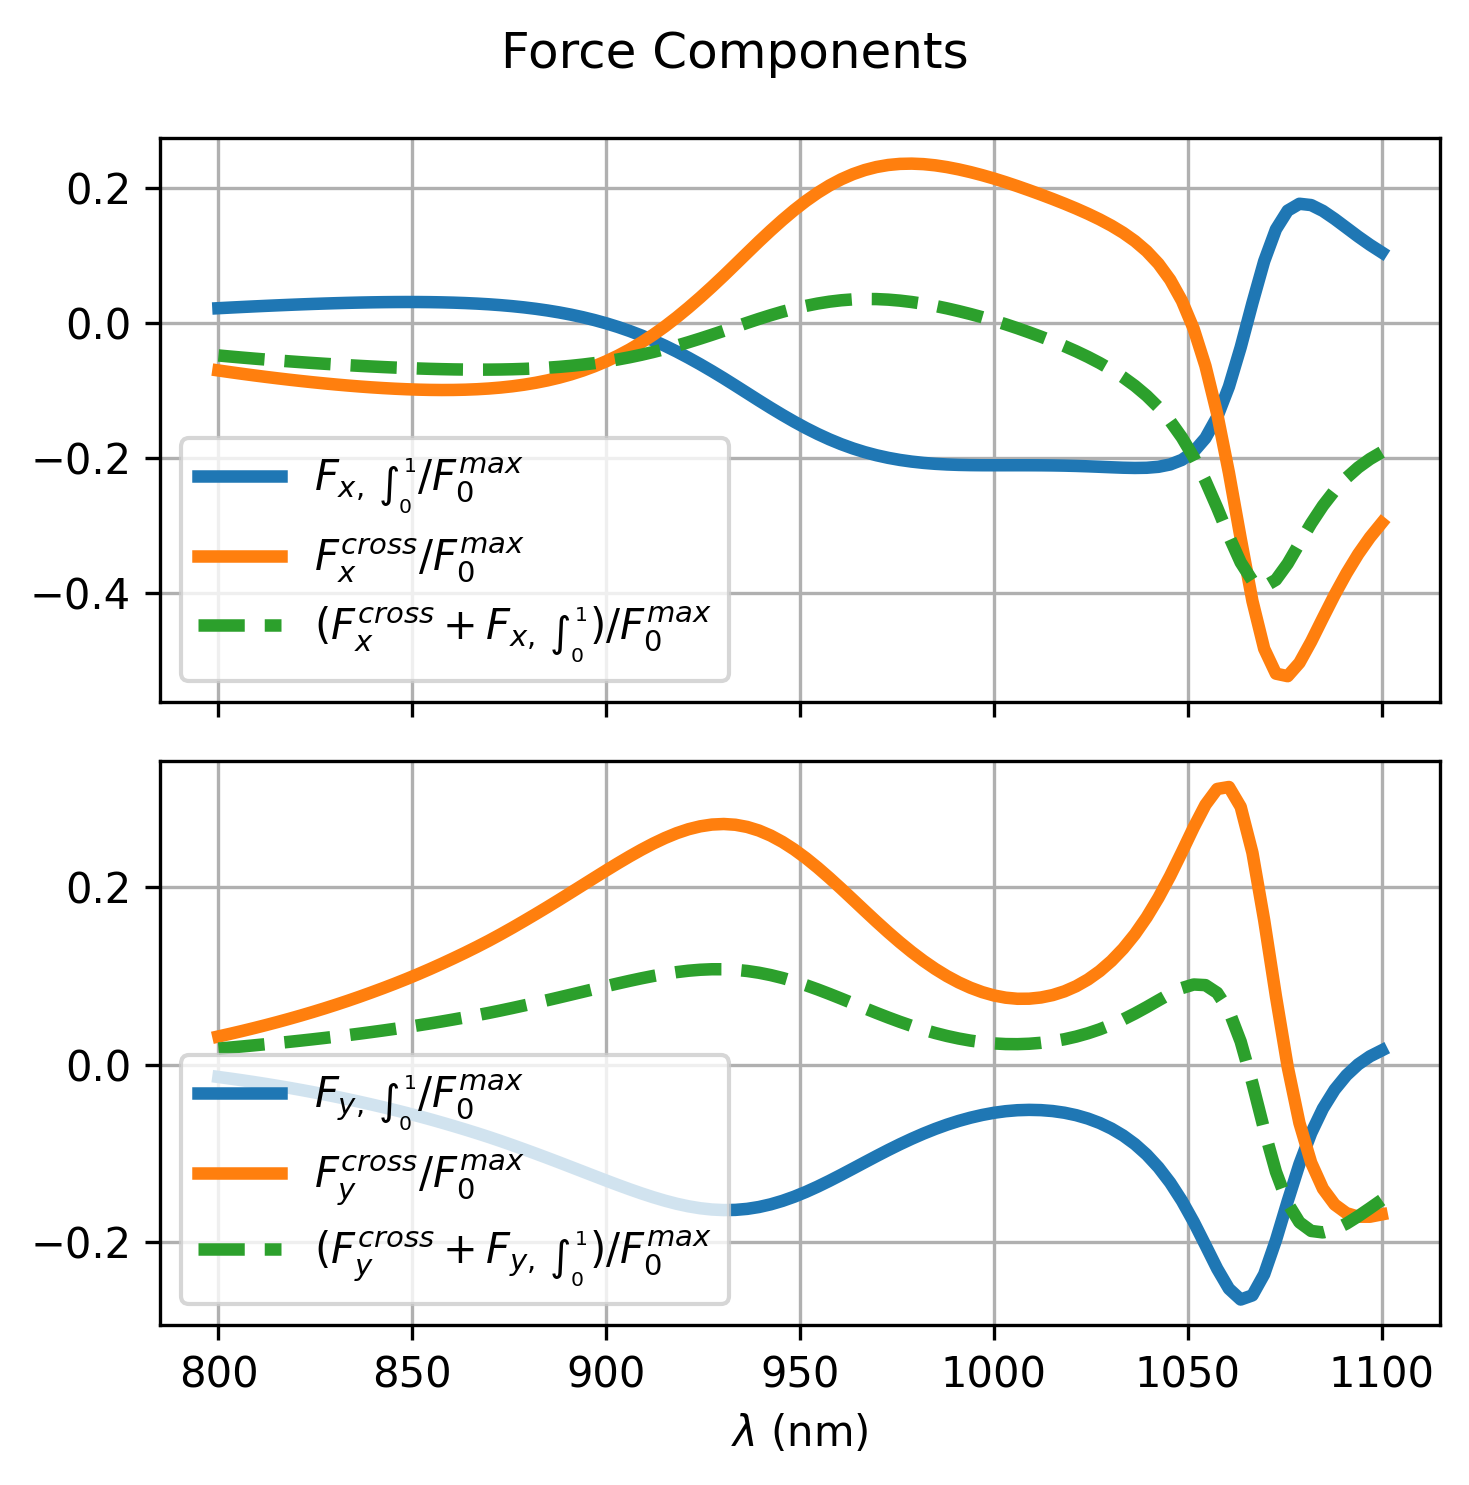

In [200]:
import numpy as np
import matplotlib.pyplot as plt

F0 = np.max(np.abs(sweep_res_free_space['Fz'].to_numpy()))

# --- 2. Угол силы ---
Fx = sweep_res["Fx"].to_numpy()
Fy = sweep_res["Fy"].to_numpy()
wl = sweep_res["wl"].apply(lambda x: x.magnitude if hasattr(x, "magnitude") else x).to_numpy()

Fxe0 = sweep_res["Fxe0"].to_numpy()
Fxm0 = sweep_res["Fxm0"].to_numpy()

Fxcross = sweep_res["Fxcross"].to_numpy()
Fycross = sweep_res["Fycross"].to_numpy()

Fx_nosc = Fx - Fxe0 - Fxm0

Fx_nosc_noncross = Fx_nosc - Fxcross
Fy_nosc_noncross = Fy - Fycross


Fxspp = sweep_res["Fxspp"].to_numpy()
Fyspp = sweep_res["Fyspp"].to_numpy()

Fx01 = Fx_nosc_noncross - Fxspp
Fy01 = Fy_nosc_noncross - Fyspp



Fx_norm      = np.array([f / F0 for f in Fx])
Fxnosc_norm  = np.array([f / F0 for f in Fx_nosc])
Fxnocross_norm = np.array([f / F0 for f in Fx_nosc_noncross])
Fxspp_norm   =  np.array([f / F0 for f in Fxspp])
Fxcross_norm   =  np.array([f / F0 for f in Fxcross])
Fx01  =  np.array([f / F0 for f in Fx01])

Fy_norm      =  np.array([f / F0 for f in Fy])
Fynocross_norm =np.array([f / F0 for f in Fy_nosc_noncross])
Fyspp_norm   = np.array([f / F0 for f in Fyspp])
Fycross_norm   =  np.array([f / F0 for f in Fycross])
Fy01  =  np.array([f / F0 for f in Fy01])

# --- графики ---
fig, axs = plt.subplots(2, 1, figsize=(5, 5),dpi=300, sharex=True)

#  X-компонента
# axs[0].plot(wl, Fx_norm, label="Fx / F0", marker="o")
#axs[0].plot(wl, Fxnosc_norm, label="$F_x^{no\\;sc}/F_0^{max}$", lw=3)
axs[0].plot(wl, Fx01, label="$F_{x,\\;\\int_0^1} / F_0^{max}$", lw=3)
# axs[0].plot(wl, Fxspp_norm, label="$F_x^{spp} / F_0^{max}$", lw=3)
axs[0].plot(wl, Fxcross_norm, label="$F_x^{cross} / F_0^{max}$", lw=3)

axs[0].plot(wl, Fxcross_norm+Fx01, label="$(F_x^{cross} +F_{x,\\;\\int_0^1})  / F_0^{max}$", ls='--',lw=3)

# axs[0].set_ylabel("$F_x^{spp} / F_0^{max}$")
axs[0].legend()
axs[0].grid(True)

# Y-компонента
#axs[1].plot(wl, Fy_norm, label="$F_y / F_0^{max}$", lw=3)
axs[1].plot(wl, Fy01, label="$F_{y,\\;\\int_0^1}/ F_0^{max}$", lw=3)
#axs[1].plot(wl, Fyspp_norm, label="$F_y^{spp} / F_0^{max}$", lw=3)
axs[1].plot(wl, Fycross_norm, label="$F_y^{cross} / F_0^{max}$", lw=3)
axs[1].plot(wl, Fycross_norm+Fy01, label="$(F_y^{cross} +F_{y,\\;\\int_0^1})  / F_0^{max}$", ls='--',lw=3)


# axs[1].set_ylabel("$F_y^{spp}$ / $F_0^{max}$")
axs[1].set_xlabel("$\\lambda$ (nm)")
axs[1].legend()
axs[1].grid(True)

plt.suptitle("Force Components")
plt.tight_layout()
plt.savefig('plots/Force_01_and_Cross.png', dpi=300)
plt.show()

In [191]:
fxfy_comsol = np.loadtxt('fx_fy.txt', delimiter=',')

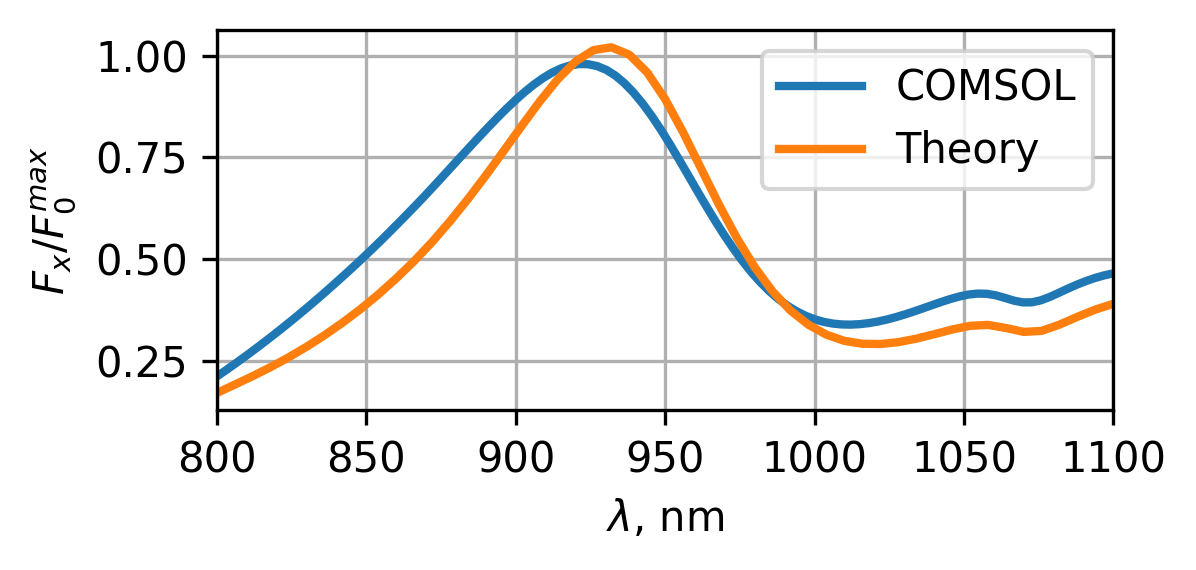

In [192]:
plt.figure(figsize=(4,2), dpi=300)
plt.plot(wl, Fx/F0.magnitude, label='COMSOL', lw=2)
plt.plot(fxfy_comsol[:,0], fxfy_comsol[:,1]/F0.magnitude, label='Theory', lw=2)
plt.ylabel('$F_x/F_0^{max}$')
plt.xlabel('$\\lambda$, nm')
plt.legend()
plt.grid()
plt.xlim(wl[0], wl[-1])
plt.tight_layout()
#plt.savefig('Fx_coms_python.png')


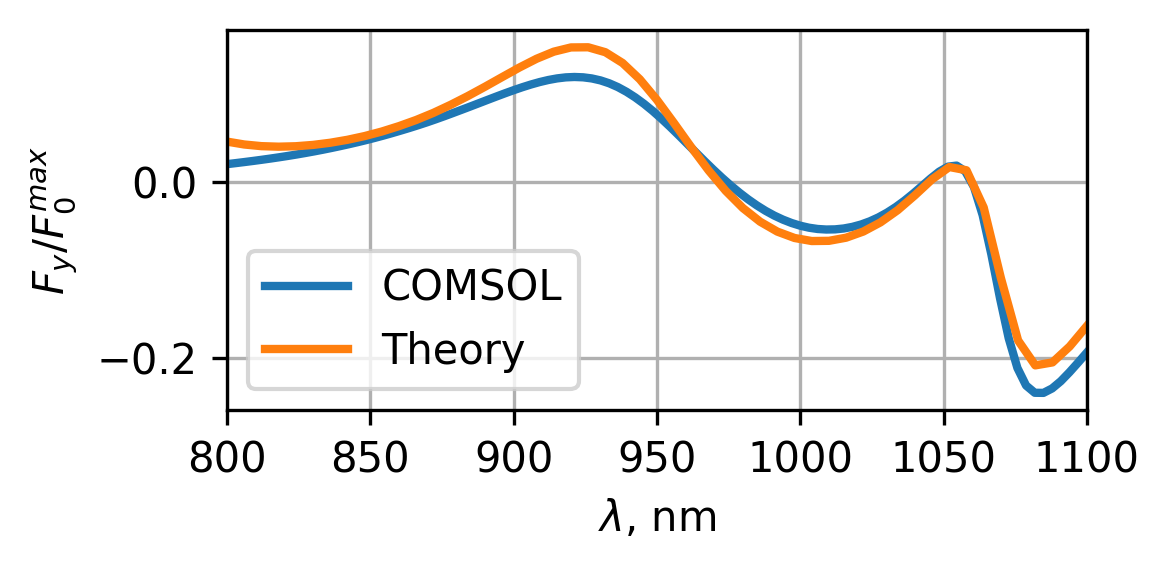

In [193]:

plt.figure(figsize=(4,2), dpi=300)
plt.plot(wl, Fy/F0.magnitude, label='COMSOL', lw=2)
plt.plot(fxfy_comsol[:,0], fxfy_comsol[:,2]/F0.magnitude, label='Theory', lw=2)
plt.ylabel('$F_y/F_0^{max}$')
plt.xlabel('$\\lambda$, nm')
plt.legend()
plt.grid()
plt.xlim(wl[0], wl[-1])
plt.tight_layout()
#plt.savefig('Fy_coms_python.png')



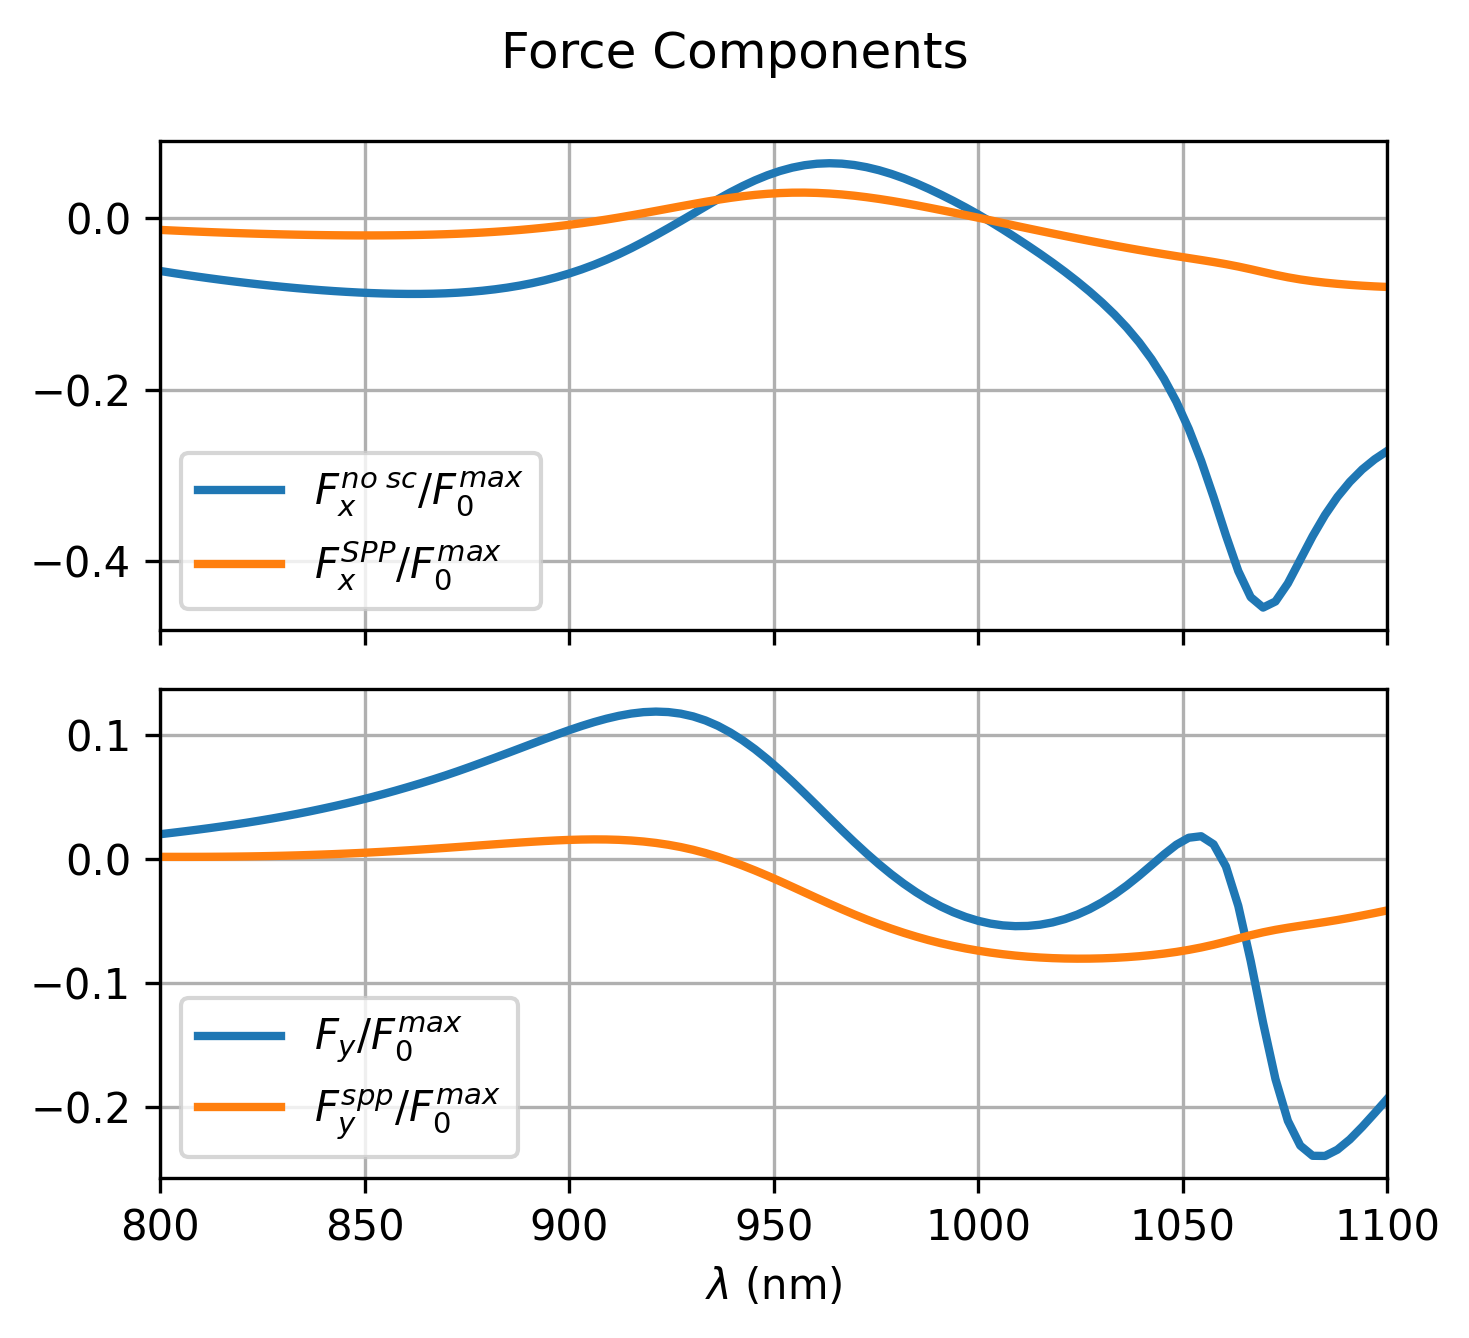

In [25]:
import numpy as np
import matplotlib.pyplot as plt

F0 = np.max(np.abs(sweep_res_free_space['Fz'].to_numpy()))

# --- 2. Угол силы ---
Fx = sweep_res["Fx"].to_numpy()
Fy = sweep_res["Fy"].to_numpy()
wl = sweep_res["wl"].apply(lambda x: x.magnitude if hasattr(x, "magnitude") else x).to_numpy()

Fxe0 = sweep_res["Fxe0"].to_numpy()
Fxm0 = sweep_res["Fxm0"].to_numpy()

Fxcross = sweep_res["Fxcross"].to_numpy()
Fycross = sweep_res["Fycross"].to_numpy()

Fx_nosc = Fx - Fxe0 - Fxm0

Fx_nosc_noncross = Fx_nosc - Fxcross
Fy_nosc_noncross = Fy - Fycross


Fxspp = sweep_res["Fxspp"].to_numpy()
Fyspp = sweep_res["Fyspp"].to_numpy()



Fx_norm      = np.array([f / F0 for f in Fx])
Fxnosc_norm  = np.array([f / F0 for f in Fx_nosc])
Fxnocross_norm = np.array([f / F0 for f in Fx_nosc_noncross])
Fxspp_norm   =  np.array([f / F0 for f in Fxspp])

Fy_norm      =  np.array([f / F0 for f in Fy])
Fynocross_norm =np.array([f / F0 for f in Fy_nosc_noncross])
Fyspp_norm   = np.array([f / F0 for f in Fyspp])

# --- графики ---
fig, axs = plt.subplots(2, 1, figsize=(5, 4.5),dpi=300, sharex=True)

#  X-компонента
#axs[0].plot(wl, Fx_norm, label="Fx / F0", marker="o")
axs[0].plot(wl, Fxnosc_norm, label="$F_x^{no\\;sc}/F_0^{max}$", lw=2)
#axs[0].plot(wl, Fxnocross_norm, label="Fx_nosc_nocross / F0", lw=2)
axs[0].plot(wl, Fxspp_norm, label="$F_x^{SPP} / F_0^{max}$", lw=2)
# axs[0].set_ylabel("$F_x^{spp} / F_0^{max}$")
axs[0].legend()
axs[0].grid(True)

# Y-компонента
axs[1].plot(wl, Fy_norm, label="$F_y / F_0^{max}$", lw=2)
# axs[1].plot(wl, Fynocross_norm, label="Fy_nosc_nocross / F0", marker="^")
axs[1].plot(wl, Fyspp_norm, label="$F_y^{spp} / F_0^{max}$", lw=2)
# axs[1].set_ylabel("$F_y^{spp}$ / $F_0^{max}$")
axs[1].set_xlabel("$\\lambda$ (nm)")
axs[1].legend()
axs[1].grid(True)

axs[0].set_xlim(wl[0],wl[-1])

plt.suptitle("Force Components")
plt.tight_layout()
plt.savefig('plots/F_nosc_and_SPP_Force_Components.png', dpi=300)
plt.show()

In [141]:
import numpy as np
import matplotlib.pyplot as plt

F0 = np.max(np.abs(sweep_res_free_space['Fz'].to_numpy()))

# --- 2. Угол силы ---
Fx = sweep_res["Fx"].to_numpy()
Fy = sweep_res["Fy"].to_numpy()
wl = sweep_res["wl"].apply(lambda x: x.magnitude if hasattr(x, "magnitude") else x).to_numpy()

Fxe0 = sweep_res["Fxe0"].to_numpy()
Fxm0 = sweep_res["Fxm0"].to_numpy()

Fxcross = sweep_res["Fxcross"].to_numpy()
Fycross = sweep_res["Fycross"].to_numpy()

Fx_nosc = Fx - Fxe0 - Fxm0

Fx_nosc_noncross = Fx_nosc - Fxcross
Fy_nosc_noncross = Fy - Fycross


Fxspp = sweep_res["Fxspp"].to_numpy()
Fyspp = sweep_res["Fyspp"].to_numpy()



Fx_norm      = np.array([f / F0 for f in Fx])
Fxnosc_norm  = np.array([f / F0 for f in Fx_nosc])
Fxnocross_norm = np.array([f / F0 for f in Fx_nosc_noncross])
Fxspp_norm   =  np.array([f / F0 for f in Fxspp])

Fy_norm      =  np.array([f / F0 for f in Fy])
Fynocross_norm =np.array([f / F0 for f in Fy_nosc_noncross])
Fyspp_norm   = np.array([f / F0 for f in Fyspp])

# --- графики ---
fig, axs = plt.subplots(2, 1, figsize=(5, 4.5),dpi=300, sharex=True)

#  X-компонента
#axs[0].plot(wl, Fx_norm, label="Fx / F0", marker="o")
axs[0].plot(wl, Fxnosc_norm, label="$F_x^{no\\;sc}/F_0^{max}$", lw=2)
axs[0].plot(wl, Fxnocross_norm, label="$(F_x^{SPP} + F_{x\\;\\int_0^1}) / F_0^{max}$", lw=2)
axs[0].plot(wl, Fxspp_norm, label="$F_x^{SPP} / F_0^{max}$", lw=2)

axs[0].legend()
axs[0].grid(True)

# Y-компонента
axs[1].plot(wl, Fy_norm, label="$F_y / F_0^{max}$", lw=2)
axs[1].plot(wl, Fynocross_norm, label="$(F_y^{SPP} + F_{y\\;\\int_0^1}) / F_0^{max}$", lw=2)
axs[1].plot(wl, Fyspp_norm, label="$F_y^{spp} / F_0^{max}$", lw=2)
# axs[1].set_ylabel("$F_y^{spp}$ / $F_0^{max}$")
axs[1].set_xlabel("$\\lambda$ (nm)")
axs[1].legend()
axs[1].grid(True)

axs[0].set_xlim(wl[0],wl[-1])

plt.suptitle("Force Components")
plt.tight_layout()
plt.savefig('plots/F_nosc_and_SPP_Force_Components_more.png', dpi=300)
plt.show()

NameError: name 'sweep_res_free_space' is not defined

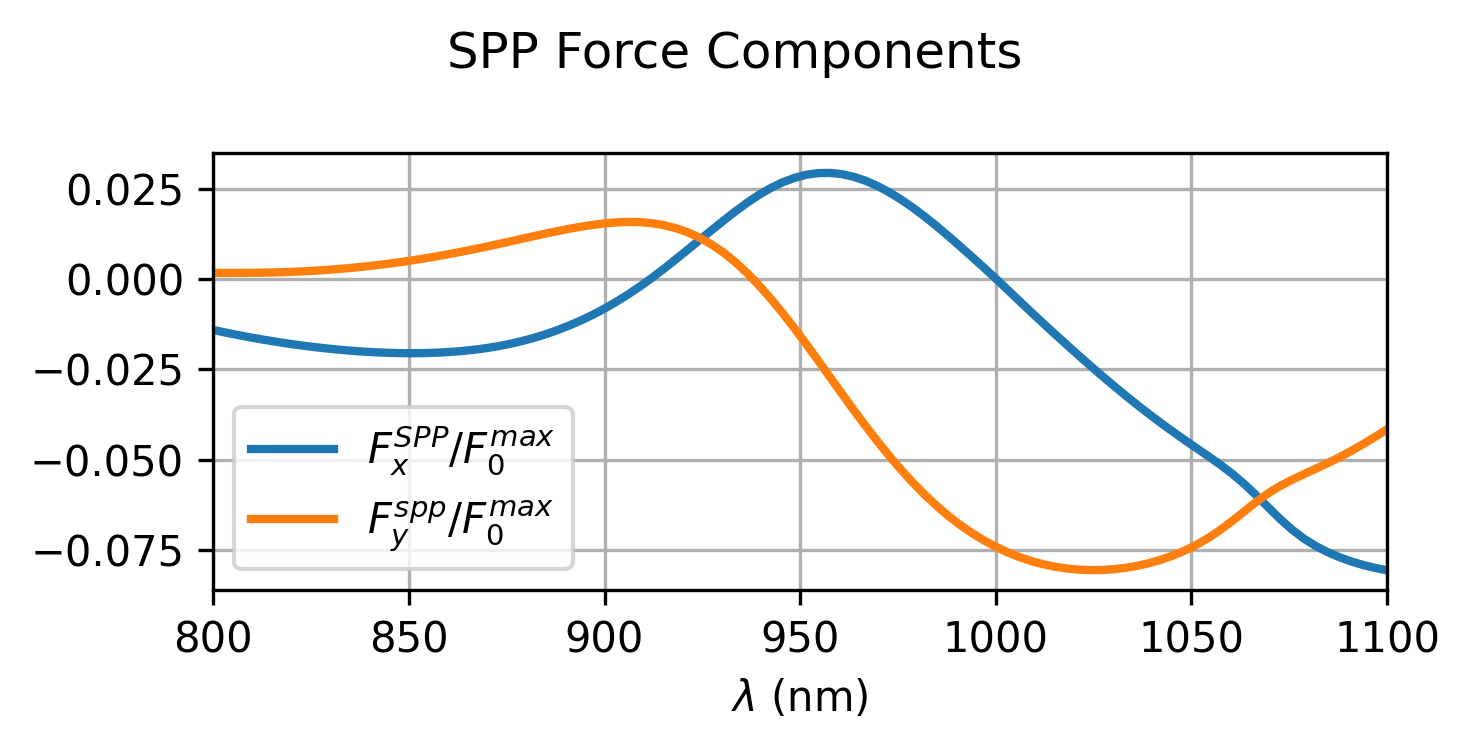

In [47]:

# --- графики ---
fig, ax = plt.subplots(1, 1, figsize=(5, 2.5),dpi=300, sharex=True)

ax.plot(wl, Fxspp_norm, label="$F_x^{SPP} / F_0^{max}$", lw=2)
ax.plot(wl, Fyspp_norm, label="$F_y^{spp} / F_0^{max}$", lw=2)

ax.set_xlabel("$\\lambda$ (nm)")
ax.legend()
ax.grid(True)

ax.set_xlim(wl[0],wl[-1])

plt.suptitle("SPP Force Components")
plt.tight_layout()
#plt.savefig('field/SPP_Force_Components.png', dpi=300)
plt.show()

In [48]:
data = pd.read_csv('relHphi_wl_m.csv', skiprows=4)

wls = data['% lambda0 (nm)'].unique()

phii = np.linspace(0, 2*np.pi, 200)

H_phi = np.zeros((len(wls), len(phii)), dtype=complex)

M_max =2 
for i in range(len(wls)):
    for j in range(2*M_max+1):
        H_phi[i,:] += (data['real(ewfd.relHphi) (A/m), Point: 13'][i*(2*M_max+1)+j] + 1j*data['imag(ewfd.relHphi) (A/m), Point: 13'][i*(2*M_max+1)+j])*np.exp(-1j*(-M_max+j)*phii)
        
from scipy.integrate import trapezoid
D_coms = np.zeros_like(H_phi)

for i in range(len(wls)):
    integr = trapezoid(np.abs(H_phi[i,:])**2, phii)
    D_coms [i, :] =  2*np.pi* np.abs(H_phi[i,:])**2 /  integr   

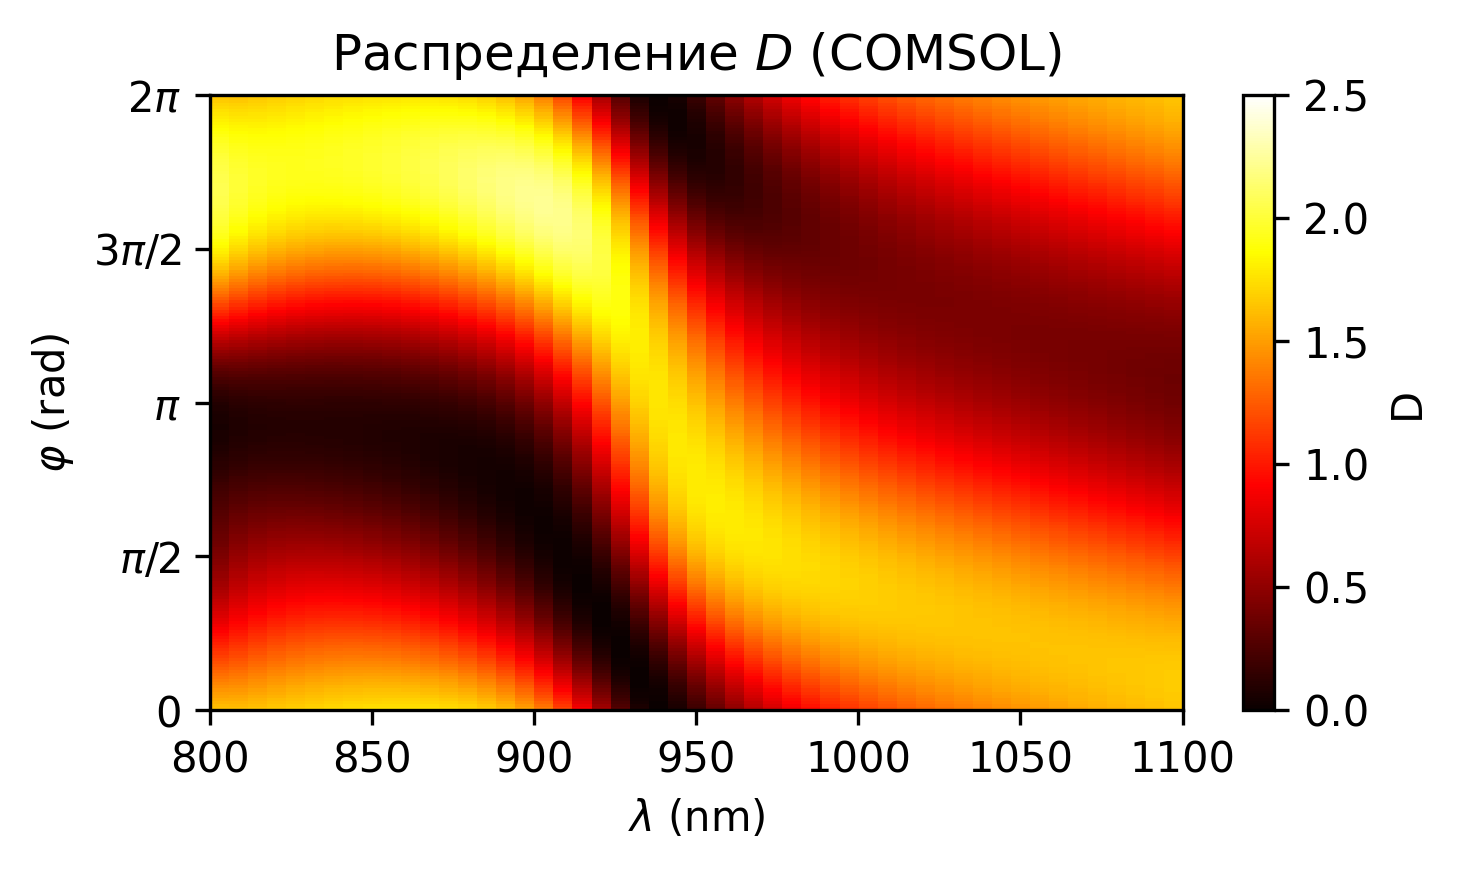

In [49]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 3), dpi=300)

plt.imshow(
    D_coms.T.real,
    aspect="auto",
    origin="lower",
    extent=[
        wls[0],   wls[-1],
        phii[0], phii[-1],
    ],
    cmap="hot",
    vmin=0, vmax=2.5
)

plt.colorbar(label="D")
plt.xlabel("$\\lambda$ (nm)")
plt.ylabel("$\\varphi$ (rad)")
plt.title("Распределение $D$ (COMSOL)")

# Установка делений по оси Y в радианах
yticks = [0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi]
yticklabels = ["$0$", "$\\pi/2$", "$\\pi$", "$3\\pi/2$", "$2\\pi$"]

plt.yticks(yticks, yticklabels)

plt.tight_layout()
#plt.savefig('D_map_comsol.png')
plt.show()

# Fcross vs Air Scattering 

In [96]:
base_config = SimulationConfig(
    wl = 926 * ureg.nanometer,
    R =  (295/2) * ureg.nanometer,
    dist = 2 * ureg.nanometer,
    angle = np.deg2rad(25),
    a_angle = np.pi/4,
    phase= np.pi/2
)

In [97]:
from MieSppForce.simulation import SphericalGrid, DiagramCalculator, OpticalForceCalculator

import matplotlib.pyplot as plt


SphGrid = SphericalGrid(r = base_config.wl*3,
                        theta= np.linspace(-np.pi/2, np.pi/2, 100)*ureg.rad,
                        phi= 0 * ureg.rad)

Field_Rad = FieldsCalculator(base_config).compute(SphGrid)

forces_single = OpticalForceCalculator(base_config).compute()

 43%|████▎     | 43/100 [01:42<02:16,  2.40s/it]c:\Users\borod\Desktop\SPP_ANALYTICAL\SPP_ANALYTICAL\.venv\Lib\site-packages\scipy\integrate\_quadpack_py.py:444: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  im_retval = quad(imfunc, a, b, args, full_output, epsabs,
100%|██████████| 100/100 [04:03<00:00,  2.44s/it]


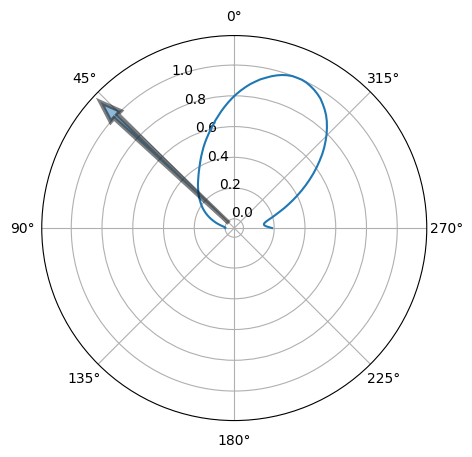

In [ ]:
fycross = forces_single.as_dict()['Fycross']
fzcross = forces_single.as_dict()['Fzcross']
fxcross = forces_single.as_dict()['Fxcross']

fx = forces_single.as_dict()['Fx']
fz = forces_single.as_dict()['Fz']

fxe0 = forces_single.as_dict()['Fxe0']
fze0 = forces_single.as_dict()['Fze0']

fxm0 = forces_single.as_dict()['Fxm0']
fzm0 = forces_single.as_dict()['Fzm0']




EXX = Field_Rad.df['Ex'].apply(lambda x: x.magnitude if hasattr(x, "magnitude") else x).to_numpy()

EYY = Field_Rad.df['Ey'].apply(lambda x: x.magnitude if hasattr(x, "magnitude") else x).to_numpy()

EZZ = Field_Rad.df['Ez'].apply(lambda x: x.magnitude if hasattr(x, "magnitude") else x).to_numpy()

HXX = Field_Rad.df['Hx'].apply(lambda x: x.magnitude if hasattr(x, "magnitude") else x).to_numpy()

HYY = Field_Rad.df['Hy'].apply(lambda x: x.magnitude if hasattr(x, "magnitude") else x).to_numpy()

HZZ = Field_Rad.df['Hz'].apply(lambda x: x.magnitude if hasattr(x, "magnitude") else x).to_numpy()


Sx = 0.5*np.real(EYY*HZZ.conj() - EZZ * HYY.conj() )
Sy = 0.5*np.real(EZZ*HXX.conj() - EXX * HZZ.conj() )
Sz = 0.5*np.real(EXX*HYY.conj() - EYY * HZZ.conj() )

absS = np.sqrt(np.abs(Sx)**2 + np.abs(Sy)**2 + np.abs(Sz)**2)


THETA = np.linspace(-np.pi/2, np.pi/2, 100)


fig, ax = plt.subplots(subplot_kw=dict(projection='polar'), figsize=(5, 5))
ax.set_theta_offset(np.pi/2)

ax.arrow(np.atan2(fxcross,fzcross).magnitude, 0, 0, 1,  alpha = 0.5, width = 0.03, edgecolor = 'black', lw = 3, zorder = 5)
# ax.plot(THETA, absS)

ax.plot(THETA, (Sx*np.sin(THETA)+Sz*np.cos(THETA))/np.max(Sx*np.sin(THETA)+Sz*np.cos(THETA)))


In [131]:
from MieSppForce.simulation import CylindricalGrid, FieldsCalculator

grid = CylindricalGrid(
    r=np.linspace(0,2000, 100)*ureg.nm,
    phi=np.linspace(0, np.pi*2, 200)* ureg.radian,
    z=np.array([0.1]) * ureg.nm
)

In [132]:
FiledSPP = FieldsCalculator(base_config).compute(grid, 'sub')
FiledAir = FieldsCalculator(base_config).compute(grid, 'air')
FiledFull = FieldsCalculator(base_config).compute(grid)

  5%|▍         | 968/20000 [00:11<03:18, 96.11it/s] c:\Users\borod\Desktop\SPP_ANALYTICAL\SPP_ANALYTICAL\.venv\Lib\site-packages\scipy\integrate\_quadpack_py.py:444: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  im_retval = quad(imfunc, a, b, args, full_output, epsabs,
 31%|███       | 6125/20000 [01:26<03:06, 74.49it/s] c:\Users\borod\Desktop\SPP_ANALYTICAL\SPP_ANALYTICAL\.venv\Lib\site-packages\scipy\integrate\_quadpack_py.py:441: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  re_retval = quad(refunc, a, b, args, full_output, epsabs,
100%|██████████| 20000/20000 [00:23<00:00, 843.81it/s]


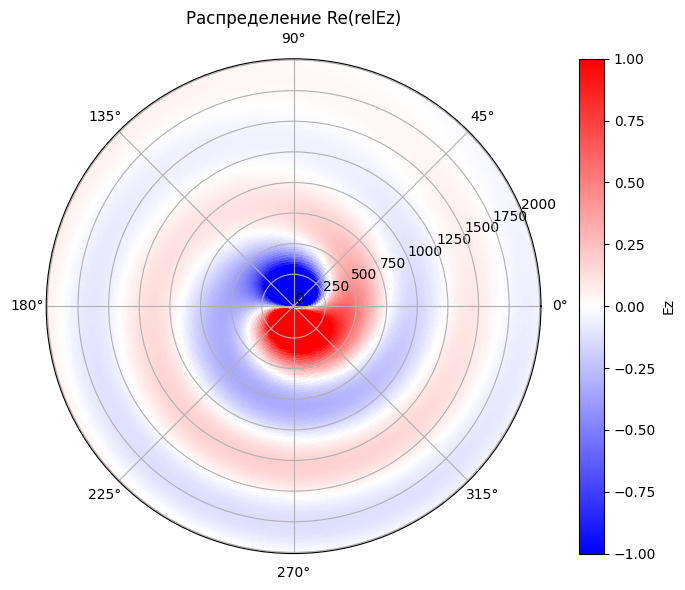

In [135]:
import matplotlib.pyplot as plt
import numpy as np

comp ='Ez'

r_vals = FiledFull.df['r'].apply(lambda x: x.to('nm').magnitude).unique()
phi_vals = FiledFull.df['phi'].apply(lambda x: x.to('rad').magnitude).unique()

r_mesh, phi_mesh = np.meshgrid(r_vals, phi_vals, indexing='ij')

comp_vals = FiledFull.df[comp].apply(lambda x: x.magnitude).values.reshape(len(r_vals), len(phi_vals))


exx = FiledAir.df['Ex'].apply(lambda x: x.magnitude).values.reshape(len(r_vals), len(phi_vals))


eyy = FiledAir.df['Ey'].apply(lambda x: x.magnitude).values.reshape(len(r_vals), len(phi_vals))

fig, ax = plt.subplots(subplot_kw=dict(projection='polar'), figsize=(8, 6))


Err = exx * np.cos(phi_mesh) + eyy * np.sin(phi_mesh)

Epp = -1 *  exx * np.sin(phi_mesh) + eyy * np.cos(phi_mesh)

c = ax.pcolormesh(phi_mesh, r_mesh, comp_vals.real , shading='auto', cmap='bwr', vmax=1, vmin=-1)

fig.colorbar(c, ax=ax, label=f"{comp}")

# fig.colorbar(c, ax=ax, label=f"{comp}", format='%.0e')

plt.tight_layout()

ax.set_title(f"Распределение Re(rel{comp})")
plt.tight_layout()
# plt.savefig(f'field/real('+comp+').png', dpi=300 )
plt.show()

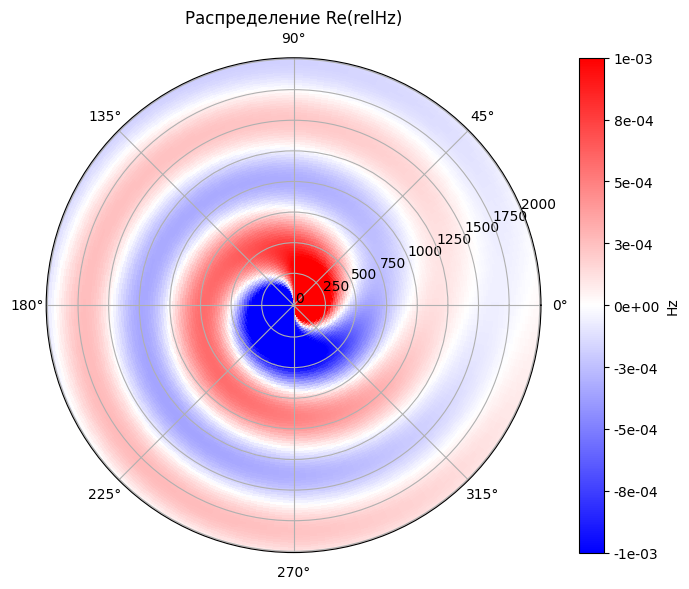

In [140]:
import matplotlib.pyplot as plt
import numpy as np

comp ='Hz'

r_vals = FiledFull.df['r'].apply(lambda x: x.to('nm').magnitude).unique()
phi_vals = FiledFull.df['phi'].apply(lambda x: x.to('rad').magnitude).unique()

r_mesh, phi_mesh = np.meshgrid(r_vals, phi_vals, indexing='ij')

comp_vals = FiledFull.df[comp].apply(lambda x: x.magnitude).values.reshape(len(r_vals), len(phi_vals))


hxx = FiledFull.df['Hx'].apply(lambda x: x.magnitude).values.reshape(len(r_vals), len(phi_vals))
hyy = FiledFull.df['Hy'].apply(lambda x: x.magnitude).values.reshape(len(r_vals), len(phi_vals))

Hrr = hxx * np.cos(phi_mesh) + hyy * np.sin(phi_mesh)

Hpp = -1 *  hxx * np.sin(phi_mesh) + hyy * np.cos(phi_mesh)


fig, ax = plt.subplots(subplot_kw=dict(projection='polar'), figsize=(8, 6))

c = ax.pcolormesh(phi_mesh, r_mesh, Hpp.real, shading='auto', cmap='bwr',vmin=-1e-3, vmax=1e-3)


fig.colorbar(c, ax=ax, label=f"{comp}", format='%.0e')



ax.set_title(f"Распределение Re(rel{comp})")
plt.tight_layout()
#plt.savefig(f'field/real('+comp+').png', dpi=300 )
plt.show()